In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import shutil
import random
import pprint
import itertools
import functools
import collections

import pysam
import pyranges as pr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats

import sys
sys.path.append('/home/users/pjh/scripts/python_genome_package_dev/')

In [2]:
from handygenome import common
from handygenome.common import ChromDict, Interval
from handygenome.variantplus.vcfspec import Vcfspec
from handygenome.sv.breakends import Breakends
from handygenome.variantplus.variantplus import VariantPlus, VariantPlusList
from handygenome.variantplus.vcfplus import VcfPlus
from handygenome.igvhandle import IGVHandle

from handygenome.variantplus import vpfilter as libvpfilter
from handygenome.vcfeditor.initvcf import create_header

[W::hts_idx_load3] The index file is older than the data file: /home/users/pjh/scripts/python_genome_packages/data/popfreq/dbSNP_b155_GRCh37.p13.vcf.gz.csi
[W::hts_idx_load3] The index file is older than the data file: /home/users/pjh/scripts/python_genome_packages/data/popfreq/dbSNP_b155_GRCh37.p13.vcf.gz.csi


In [3]:
FASTA_PATH_HG19 = "/home/users/data/01_reference/human_g1k_v37/human_g1k_v37.fasta"
FASTA_PATH_HG38 = "/home/users/data/01_reference/human_g1k_v38/Homo_sapiens_assembly38.fasta"

FASTA_HG19 = pysam.FastaFile(FASTA_PATH_HG19)
FASTA_HG38 = pysam.FastaFile(FASTA_PATH_HG38)
CHROMDICT_HG19 = ChromDict(fasta_path=FASTA_PATH_HG19)
CHROMDICT_HG38 = ChromDict(fasta_path=FASTA_PATH_HG38)

# Basic setups

In [4]:
SAMPLEIDS = [
    '14', '6', '87', 'F13', 'F2', 'F33', 'F37', 'FF1', 'FF104', 'FF115', 'FF13', 'FF18', 'FF20', 'FF21', 'FF23', 'FF24', 'FF27', 
    'FF3', 'FF31', 'FF34', 'FF37', 'FF39', 'FF4', 'FF43', 'FF53', 'FF56', 'FF57', 'FF58', 'FF6', 'FF62', 'FF67', 'FF71', 'FF76', 
    'FF77', 'FF78', 'FF79', 'FF80', 'FF85', 
    #'IO04',  # swapped sample
    'IO05', 'IO06', 'IO07', 'IO08', 'IO09', 'IO12', 'IO13', 'IO15', 'IO16', 'IO17', 
    'IO18', 'IO22', 'IO23', 'IO24', 'IO25', 'SC126', 'SC134', 'SC31', 'SC81', 'SC88', 'SC97', 'SC98', 
]
SAMPLEIDS_LU = [f'LU-{x}' for x in SAMPLEIDS]
SAMPLEIDS_LU_PANEL = [f'{x}_panel' for x in SAMPLEIDS_LU]
SAMPLEIDS_LU_TUMOR = [f'{x}_tumor' for x in SAMPLEIDS_LU]

SAMPLEIDS_ALIASES = {
    'LC-S23': 'LU-F13',
    'LC-S9': 'LU-F2',
    'LU-IO02': 'LU-F33',
    'LC-S2': 'LU-F37',
    'LU-IO14': 'LU-FF80',
    'LU-IO21': 'LU-SC134',
    'LU-IO01': 'LU-SC31',
    'LC-S6m': 'LU-SC81',
    'LU-IO19': 'LU-SC88',
    'LU-IO20': 'LU-SC98',
}

BAM_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/'
PANEL_REGION_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/exon_intron_targetregions_merged.bed'
PANEL_REGION_EXONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_exon_Regions_tracknamechanged.bed'
PANEL_REGION_INTRONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_intron_Regions_tracknamechanged.bed'
WGS_TMB_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/wgs_TMB_previously_found_210312.txt'

In [5]:
sampletype_filename_map = {
    'tumor': ['tumor'], 
    'normal': ['normal'], 
    'panel': ['panel'], 
    'rna': ['RNA', 'RNA_GFP'],
}
BAM_PATHS = {sampletype: dict() for sampletype in sampletype_filename_map.keys()}

for top, dirs, files in os.walk(BAM_TOPDIR):
    for f in files:
        for sampleid in SAMPLEIDS_LU:
            for sampletype, fname_portions in sampletype_filename_map.items():
                if f in (f'{sampleid}.{fname_portion}.bam' for fname_portion in fname_portions):
                    BAM_PATHS[sampletype][sampleid] = os.path.join(top, f)

In [6]:
BAMS = {
    sampletype: {
        sampleid: pysam.AlignmentFile(bampath) 
        for sampleid, bampath in bampathdic.items()
    }
    for sampletype, bampathdic in BAM_PATHS.items()
}

In [7]:
_sampleid_keys = ['LU-14', 'LU-6', 'LU-87', 'LU-F13', 'LU-F2', 'LU-F33', 'LU-F37', 'LU-FF1', 'LU-FF104', 'LU-FF115', 'LU-FF13', 'LU-FF18', 'LU-FF20', 'LU-FF21', 'LU-FF23', 'LU-FF24', 'LU-FF27', 'LU-FF3', 'LU-FF31', 'LU-FF34', 'LU-FF37', 'LU-FF39', 'LU-FF4', 'LU-FF43', 'LU-FF53', 'LU-FF56', 'LU-FF57', 'LU-FF58', 'LU-FF6', 'LU-FF62', 'LU-FF67', 'LU-FF71', 'LU-FF76', 'LU-FF77', 'LU-FF78', 'LU-FF79', 'LU-FF80', 'LU-FF85', 'LU-IO04', 'LU-IO05', 'LU-IO06', 'LU-IO07', 'LU-IO08', 'LU-IO09', 'LU-IO12', 'LU-IO13', 'LU-IO15', 'LU-IO16', 'LU-IO17', 'LU-IO18', 'LU-IO22', 'LU-IO23', 'LU-IO24', 'LU-IO25', 'LU-SC126', 'LU-SC134', 'LU-SC31', 'LU-SC81', 'LU-SC88', 'LU-SC97', 'LU-SC98',]

PREVIOUS_PURITY = dict(zip(
    _sampleid_keys,
    [0.31, 0.16, 0.24, 0.75, 0.28, 0.5, 0.34, 0.17, 0.45, 0.43, 0.21, 0.86, 0.32, 0.37, 0.35, 0.5, 0.48, 0.2, 0.11, 0.19, 0.75, 0.21, 0.15, 0.34, 0.33, 0.37, 0.21, 0.14, 0.47, 0.52, 0.28, 0.11, 0.54, 0.27, 0.36, 0.36, 0.28, 0.24, 0.1, 0.36, 0.23, 0.24, 0.65, 0.31, 0.49, 0.69, 0.41, 0.32, 0.5, 0.42, 0.57, 0.11, 0.2, 0.28, 0.11, 0.4, 0.22, 0.4, 0.13, 0.15, 0.51,],
))

PREVIOUS_PLOIDY = dict(zip(
    _sampleid_keys,
    [2.6, 2.3, 2.7, 2.4, 1.9, 4.8, 1.9, 2.7, 2, 1.9, 2.9, 2.6, 4.5, 2.9, 2.8, 3.6, 2.1, 2.5, 2.3, 2, 2.4, 2, 2.6, 4.1, 5.7, 2.7, 3.45, 2.3, 2.1, 3.5, 2.2, 2.3, 2, 2.2, 2.9, 2, 2.2, 2.8, 2.1, 2.7, 2.4, 4.5, 2.3, 3.1, 3.5, 3.5, 5.3, 1.9, 3.3, 2.1, 2.9, 1.8, 4.4, 3.3, 2.4, 3.1, 3.7, 3.3, 1.6, 2.5, 1.9,],
))

MEAN_DEPTH_WGS_NORMAL = dict(zip(
    _sampleid_keys,
    [37.3767, 34.0972, 33.8064, 32.7928, 35.8954, 50.7577, 35.2345, 44.4876, 31.9701, 32.5393, 29.2703, 35.8483, 30.652, 30.3674, 30.7484, 37.0206, 32.9964, 32.02, 44.0783, 31.1997, 35.246, 25.3979, 27.8882, 32.5782, 32.0687, 29.2798, 35.0811, 31.21, 31.6326, 30.6922, 34.1979, 36.7596, 46.6577, 31.1763, 33.2672, 30.7369, 49.3219, 39.396, 50.6684, 47.5066, 42.1341, 50.5406, 61.0353, 48.3776, 47.3945, 47.8588, 53.5356, 50.1395, 51.1773, 48.859, 62.2889, 48.3631, 50.9241, 49.4595, 38.866, 48.8294, 60.0835, 39.58, 48.9517, 38.0445, 50.1143, ],
))

MEAN_DEPTH_WGS_TUMOR = dict(zip(
    _sampleid_keys,
    [33.8314, 28.6972, 39.9078, 31.2967, 35.1856, 50.3825, 32.995, 44.5512, 43.6843, 37.4389, 44.6266, 51.0667, 45.7373, 49.1081, 48.7203, 44.3134, 39.4903, 43.6447, 43.191, 46.8438, 32.9415, 43.3598, 47.5503, 48.4404, 47.5455, 42.8442, 36.943, 30.8365, 46.2036, 45.757, 46.2073, 41.2358, 32.9015, 38.2982, 37.7461, 35.5173, 47.0067, 50.212, 47.7919, 49.4914, 40.2729, 48.2904, 48.8819, 49.3573, 48.2809, 48.1625, 46.9765, 48.5246, 47.191, 57.4008, 45.9216, 61.224, 58.4995, 54.2237, 39.9667, 46.8006, 46.7105, 29.9816, 46.1059, 35.9943, 59.4945,],
))

MEAN_DEPTH_PANEL = dict(zip(
    _sampleid_keys,
    [925.555, 828.655, 1056.57, 949.034, 658.752, 943.504, 865.002, 1005.13, 1017.37, 928.113, 704.835, 1038.69, 841.098, 796.267, 861.94, 1199.86, 982.991, 622.94, 755.689, 883.229, 763.161, 994.175, 832.632, 886.978, 870.606, 940.946, 1123.63, 973.926, 867.741, 930.398, 983.845, 933.354, 992.087, 1019.04, 1027.85, 875.693, 860.521, 864.663, 934.823, 894.882, 1150.48, 866.108, 1018.39, 961.328, 1079.97, 792.767, 793.318, 362.512, 858.098, 1006.79, 1154.51, 837.199, 786.832, 1094.11, 689.674, 798.415, 1001.33, 1079.07, 760.339, 761.318, 880.314, ],
))

PANEL_ONTARGET_RATIO = dict(zip(
    _sampleid_keys,
    [0.911, 0.872, 0.79, 0.917, 0.838, 0.761, 0.701, 0.934, 0.924, 0.913, 0.696, 0.718, 0.85, 0.905, 0.87, 0.899, 0.879, 0.66, 0.783, 0.885, 0.761, 0.912, 0.789, 0.868, 0.63, 0.74, 0.808, 0.835, 0.891, 0.698, 0.914, 0.925, 0.922, 0.91, 0.923, 0.86, 0.822, 0.795, 0.758, 0.834, 0.88, 0.926, 0.924, 0.895, 0.869, 0.842, 0.72, 0.838, 0.798, 0.871, 0.91, 0.872, 0.826, 0.904, 0.858, 0.84, 0.881, 0.929, 0.806, 0.831, 0.867, ],
))

GENDER = dict(zip(
    _sampleid_keys,
    ['M', 'F', 'F', 'F', 'M', 'F', 'M', 'M', 'F', 'F', 'M', 'M', 'F', 'F', 'F', 'F', 'M', 'F', 'F', 'M', 'F', 'M', 'F', 'F', 'M', 'M', 'F', 'M', 'M', 'M', 'F', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M']
))

AGE = dict(zip(
    _sampleid_keys,
    [56, 72, 74, 62, 69, 49, 62, 79, 74, 48, 80, 78, 55, 58, 44, 68, 64, 77, 48, 72, 47, 31, 74, 80, 66, 67, 45, 48, 78, 73, 49, 49, 55, 70, 44, 71, 62, 50, 67, 74, 51, 67, 53, 75, 71, 58, 62, 56, 63, 70, 88, 54, 48, 59, 57, 60, 75, 58, 61, 50, 62, ]
))

In [8]:
PANEL_REGION_GR = pr.read_bed(PANEL_REGION_PATH)

In [9]:
WHOLE_GENOME_LENGTH = 3_095_677_412
PANEL_REGION_LENGTH = 1_890_272

In [10]:
igv = IGVHandle(60387)

# Load sequenza segments

In [12]:
WGS_SEGMENTS_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/05_sequenza/'
WGS_SEGMENTS_PATHS = dict()
for top, dirs, fnames in os.walk(WGS_SEGMENTS_TOPDIR):
    if not top.endswith('sequenza_files/analysis_files'):
        # continue
        pass

    for fname in fnames:
        if fname.endswith('tumor_segments.txt'):
            sampleid = 'LU-' + fname.split('_')[0]
            WGS_SEGMENTS_PATHS[sampleid] = os.path.join(top, fname)
del WGS_SEGMENTS_PATHS['LU-IO04']

###

PANEL_SEGMENTS_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/14_sequenza_panel/seqz_with_custom_input'
PANEL_SEGMENTS_SMALLBIN_PATHS = dict()
PANEL_SEGMENTS_PATHS = dict()
for top, dirs, fnames in os.walk(PANEL_SEGMENTS_TOPDIR):
    if not (top.endswith('sequenza_results') or top.endswith('sequenza_results_smallbin')):
        continue
        # pass

    for fname in fnames:
        if fname.endswith('_segments.txt'):
            sampleid = re.match('LU-[a-zA-Z0-9]+', fname).group(0)
            if top.endswith('sequenza_results'):
                PANEL_SEGMENTS_PATHS[sampleid] = os.path.join(top, fname)
            elif top.endswith('sequenza_results_smallbin'):
                PANEL_SEGMENTS_SMALLBIN_PATHS[sampleid] = os.path.join(top, fname)
del PANEL_SEGMENTS_PATHS['LU-IO04']
del PANEL_SEGMENTS_SMALLBIN_PATHS['LU-IO04']


# segment_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/05_sequenza/14/sequenza_files/analysis_files/14_tumor_segments.txt'
# segment_df = cnvreader.read_sequenza_segment(segment_path)

In [13]:
from handygenome.cnv import cnvreader
WGS_SEGMENTS_DFS = {key: cnvreader.read_sequenza_segment(val) for (key, val) in WGS_SEGMENTS_PATHS.items()}
PANEL_SEGMENTS_SMALLBIN_DFS = {key: cnvreader.read_sequenza_segment(val) for (key, val) in PANEL_SEGMENTS_SMALLBIN_PATHS.items()}
PANEL_SEGMENTS_DFS = {key: cnvreader.read_sequenza_segment(val) for (key, val) in PANEL_SEGMENTS_PATHS.items()}

# Load depth

In [14]:
WGS_DEPTH_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/23_binned_depths/quick_results/'
WGS_TUMOR_DEPTH_PATHS = dict()
WGS_NORMAL_DEPTH_PATHS = dict()
for top, dirs, fnames in os.walk(WGS_DEPTH_TOPDIR):
    for fname in fnames:
        if fname.endswith('regions.bed.gz'):
            sampleid = fname.split('.')[0]
            if 'tumor' in fname:
                WGS_TUMOR_DEPTH_PATHS[sampleid] = os.path.join(top, fname)
            elif 'normal' in fname:
                WGS_NORMAL_DEPTH_PATHS[sampleid] = os.path.join(top, fname)
                
PANEL_DEPTH_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/23_binned_depths/region_depth_files/'
PANEL_DEPTH_PATHS = dict()
for top, dirs, fnames in os.walk(PANEL_DEPTH_TOPDIR):
    for fname in fnames:
        if fname.endswith('regions.bed.gz'):
            sampleid = fname.split('.')[0]
            PANEL_DEPTH_PATHS[sampleid] = os.path.join(top, fname)

In [15]:
from handygenome.cnv import cnvreader
WGS_TUMOR_DEPTH_DFS = {key: cnvreader.read_depth_bed(val) for (key, val) in WGS_TUMOR_DEPTH_PATHS.items()}
WGS_NORMAL_DEPTH_DFS = {key: cnvreader.read_depth_bed(val) for (key, val) in WGS_NORMAL_DEPTH_PATHS.items()}
PANEL_DEPTH_DFS = {key: cnvreader.read_depth_bed(val) for (key, val) in PANEL_DEPTH_PATHS.items()}

# Load SV dataframes

In [11]:
from handygenome.sv import svreader

def converter_pos(x):
    if isinstance(x, str):
        return int(re.sub(',', '', x))
    else:
        return x
    
def converter_chr(x):
    if np.isnan(x):
        return x
    elif isinstance(x, str):
        return x
    else:
        return str(int(x))
    
panel_sv_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/22_panel_SV_curated/panelonly_delly_results_new_v3.csv'
panel_sv_df = pd.read_table(panel_sv_path, sep=',', header=0)

# change dtypes
for key in ('POS1', 'POS2', 'POS1_edit', 'POS2_edit'):
    panel_sv_df.loc[:, key] = panel_sv_df.loc[:, key].apply(converter_pos)
for key in ('CHR1', 'CHR2', 'CHR1_edit', 'CHR2_edit'):
    panel_sv_df.loc[:, key] = panel_sv_df.loc[:, key].apply(converter_chr)
    
# replace NaN and filter out remaining NaN rows
for key in ('POS1', 'POS2', 'CHR1', 'CHR2'):
    isnull = panel_sv_df.loc[:, key].isnull()
    panel_sv_df.loc[isnull, key] = panel_sv_df.loc[isnull, key + '_edit']
    isnull2 = panel_sv_df.loc[:, key].isnull()
    panel_sv_df = panel_sv_df.loc[np.logical_not(isnull2), :]
    
# change dtype into int
for key in ('POS1', 'POS2'):
    panel_sv_df.loc[:, key] = panel_sv_df.loc[:, key].astype('int')
    
# # filter out non-INV-DUP-DEL-TRA
# panel_sv_df = panel_sv_df.loc[
#     panel_sv_df['SVTYPE_edit'].apply(lambda x: x in ('DEL', 'INV', 'DUP', 'TRA')),
#     :
# ]
    
# rename
panel_sv_df.loc[:, 'CHROM_site1'] = panel_sv_df['CHR1']
panel_sv_df.loc[:, 'CHROM_site2'] = panel_sv_df['CHR2']
panel_sv_df.loc[:, 'POS0_site1'] = panel_sv_df['POS1'] - 1
panel_sv_df.loc[:, 'POS0_site2'] = panel_sv_df['POS2'] - 1
panel_sv_df.loc[:, 'svtype'] = panel_sv_df.loc[:, 'SVTYPE_edit']

# add color
svreader.add_color_to_sv_df(panel_sv_df)

In [12]:
PANEL_SV_DFS = dict()
for sampleid in set(panel_sv_df['sampleID']):
    PANEL_SV_DFS[sampleid] = panel_sv_df.loc[panel_sv_df['sampleID'] == sampleid, :]

In [13]:
WGS_SV_TOPDIR1 = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/links_other_projects/previous_sv_results/'
WGS_SV_TOPDIR2 = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/links_other_projects/previous_sv_results_nonalk/'
WGS_SV_TOPDIR3 = '/home/users/team_projects/LungCancer_IO_WGS/01_WGS/09_delly/filtered_bam_delly_mask/delly_annotation_files'

WGS_SV_PATHS = dict()
for topdir in (WGS_SV_TOPDIR1, WGS_SV_TOPDIR2):
    for top, dirs, fnames, in os.walk(topdir):
        for fname in fnames:
            if fname.endswith('anv'):
                sampleid = fname.split('.')[0]
                if sampleid in SAMPLEIDS_ALIASES:
                    print('alias')
                    sampleid = SAMPLEIDS_ALIASES[sampleid]                                
                    
                if sampleid in SAMPLEIDS_LU:
                # if sampleid.startswith('LU-'):
                    WGS_SV_PATHS[sampleid] = os.path.join(top, fname)
                    
for top, dirs, fnames, in os.walk(WGS_SV_TOPDIR3):
    for fname in fnames:
        if fname.endswith('fi_sim'):
            sampleid = 'LU-IO' + fname.split('.')[0].split('_')[-1]
            if sampleid in SAMPLEIDS_ALIASES:
                print('alias', sampleid)
                sampleid = SAMPLEIDS_ALIASES[sampleid]                                

            if sampleid in SAMPLEIDS_LU:
            # if sampleid.startswith('LU-'):
                WGS_SV_PATHS[sampleid] = os.path.join(top, fname)

                    

# sv_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/links_other_projects/previous_sv_results/LU-14.SV_final.181230.txt.anv'


alias LU-IO01
alias LU-IO14
alias LU-IO20
alias LU-IO21
alias LU-IO19
alias LU-IO02
alias LU-IO01
alias LU-IO14
alias LU-IO20
alias LU-IO21
alias LU-IO19
alias LU-IO02


In [14]:
from handygenome.sv import svreader

WGS_SV_DFS = dict()
for key, val in WGS_SV_PATHS.items():
    try:
        df = svreader.previous_sv_reader(val)
        WGS_SV_DFS[key] = df
    except:
        print(key)
        raise

In [16]:
for sampleid in SAMPLEIDS_LU:
    print(sampleid)
    # if sampleid not in WGS_SV_DFS:
    #     print(sampleid)

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


# Load previous WGS SNV/INDEL results

In [19]:
PREVIOUS_WGS_REANNOT_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/previous_wgs_results/reannot_220914'
PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV = dict()
PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL = dict()

for fname in os.listdir(PREVIOUS_WGS_REANNOT_TOPDIR):
    if fname.endswith('.annot.readstats.vcf.gz'):
        sampleid = fname.split('.')[0]
        if 'snv' in fname:
            PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV[sampleid] = os.path.join(PREVIOUS_WGS_REANNOT_TOPDIR, fname)
        elif 'indel' in fname:
            PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL[sampleid] = os.path.join(PREVIOUS_WGS_REANNOT_TOPDIR, fname)

In [20]:
WGS_SNV_DFS = dict()
for key, val in PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV.items():
    print(key, 'snv')
    WGS_SNV_DFS[key] = VcfPlus(val, init_all_attrs=False, init_readstats=True).vplist.get_df()
    
WGS_INDEL_DFS = dict()
for key, val in PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL.items():
    print(key, 'indel')
    WGS_INDEL_DFS[key] = VcfPlus(val, init_all_attrs=False, init_readstats=True).vplist.get_df()

LU-IO18 snv


[KST 2022-10-06 00:36:14 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line


LU-F13 snv
LU-FF71 snv
LU-IO16 snv


[KST 2022-10-06 00:36:20 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:36:23 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line


LU-IO25 snv


[KST 2022-10-06 00:36:28 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:36:31 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line


LU-IO15 snv


[KST 2022-10-06 00:36:38 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line


LU-F33 snv
LU-IO23 snv


[KST 2022-10-06 00:36:44 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:36:47 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line
[KST 2022-10-06 00:36:51 INFO] handygenome.variantplus.vcfplus: Processing 30,000th line


LU-F37 snv
LU-FF62 snv


[KST 2022-10-06 00:36:56 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:36:59 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line
[KST 2022-10-06 00:37:03 INFO] handygenome.variantplus.vcfplus: Processing 30,000th line
[KST 2022-10-06 00:37:06 INFO] handygenome.variantplus.vcfplus: Processing 40,000th line
[KST 2022-10-06 00:37:09 INFO] handygenome.variantplus.vcfplus: Processing 50,000th line
[KST 2022-10-06 00:37:12 INFO] handygenome.variantplus.vcfplus: Processing 60,000th line
[KST 2022-10-06 00:37:16 INFO] handygenome.variantplus.vcfplus: Processing 70,000th line
[KST 2022-10-06 00:37:19 INFO] handygenome.variantplus.vcfplus: Processing 80,000th line
[KST 2022-10-06 00:37:23 INFO] handygenome.variantplus.vcfplus: Processing 90,000th line
[KST 2022-10-06 00:37:26 INFO] handygenome.variantplus.vcfplus: Processing 100,000th line
[KST 2022-10-06 00:37:29 INFO] handygenome.variantplus.vcfplus: Processing 110,000th line
[KST 2022-10-06 00:

LU-FF6 snv
LU-FF3 snv
LU-FF67 snv
LU-IO07 snv


[KST 2022-10-06 00:37:58 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:38:02 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line
[KST 2022-10-06 00:38:05 INFO] handygenome.variantplus.vcfplus: Processing 30,000th line
[KST 2022-10-06 00:38:08 INFO] handygenome.variantplus.vcfplus: Processing 40,000th line
[KST 2022-10-06 00:38:11 INFO] handygenome.variantplus.vcfplus: Processing 50,000th line
[KST 2022-10-06 00:38:15 INFO] handygenome.variantplus.vcfplus: Processing 60,000th line
[KST 2022-10-06 00:38:18 INFO] handygenome.variantplus.vcfplus: Processing 70,000th line
[KST 2022-10-06 00:38:22 INFO] handygenome.variantplus.vcfplus: Processing 80,000th line
[KST 2022-10-06 00:38:25 INFO] handygenome.variantplus.vcfplus: Processing 90,000th line
[KST 2022-10-06 00:38:28 INFO] handygenome.variantplus.vcfplus: Processing 100,000th line
[KST 2022-10-06 00:38:32 INFO] handygenome.variantplus.vcfplus: Processing 110,000th line
[KST 2022-10-06 00:

LU-FF4 snv
LU-IO13 snv


[KST 2022-10-06 00:38:58 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:39:02 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line
[KST 2022-10-06 00:39:05 INFO] handygenome.variantplus.vcfplus: Processing 30,000th line


LU-14 snv
LU-FF79 snv


[KST 2022-10-06 00:39:14 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line


LU-FF21 snv
LU-FF18 snv


[KST 2022-10-06 00:39:21 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:39:25 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line


LU-FF13 snv
LU-FF58 snv
LU-SC31 snv
LU-SC126 snv
LU-IO12 snv


[KST 2022-10-06 00:39:38 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:39:41 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line
[KST 2022-10-06 00:39:45 INFO] handygenome.variantplus.vcfplus: Processing 30,000th line
[KST 2022-10-06 00:39:48 INFO] handygenome.variantplus.vcfplus: Processing 40,000th line


LU-FF78 snv
LU-IO22 snv


[KST 2022-10-06 00:39:53 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:39:56 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line
[KST 2022-10-06 00:39:59 INFO] handygenome.variantplus.vcfplus: Processing 30,000th line
[KST 2022-10-06 00:40:02 INFO] handygenome.variantplus.vcfplus: Processing 40,000th line
[KST 2022-10-06 00:40:06 INFO] handygenome.variantplus.vcfplus: Processing 50,000th line


LU-SC88 snv


[KST 2022-10-06 00:40:11 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:40:14 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line


LU-FF24 snv


[KST 2022-10-06 00:40:21 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line


LU-SC81 snv
LU-FF53 snv


[KST 2022-10-06 00:40:27 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:40:30 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line
[KST 2022-10-06 00:40:33 INFO] handygenome.variantplus.vcfplus: Processing 30,000th line
[KST 2022-10-06 00:40:37 INFO] handygenome.variantplus.vcfplus: Processing 40,000th line
[KST 2022-10-06 00:40:40 INFO] handygenome.variantplus.vcfplus: Processing 50,000th line
[KST 2022-10-06 00:40:43 INFO] handygenome.variantplus.vcfplus: Processing 60,000th line
[KST 2022-10-06 00:40:47 INFO] handygenome.variantplus.vcfplus: Processing 70,000th line
[KST 2022-10-06 00:40:50 INFO] handygenome.variantplus.vcfplus: Processing 80,000th line
[KST 2022-10-06 00:40:54 INFO] handygenome.variantplus.vcfplus: Processing 90,000th line
[KST 2022-10-06 00:40:58 INFO] handygenome.variantplus.vcfplus: Processing 100,000th line
[KST 2022-10-06 00:41:01 INFO] handygenome.variantplus.vcfplus: Processing 110,000th line
[KST 2022-10-06 00:

LU-FF34 snv
LU-SC134 snv


[KST 2022-10-06 00:41:23 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line


LU-87 snv
LU-FF115 snv
LU-FF56 snv


[KST 2022-10-06 00:41:31 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line


LU-FF80 snv


[KST 2022-10-06 00:41:38 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:41:41 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line
[KST 2022-10-06 00:41:44 INFO] handygenome.variantplus.vcfplus: Processing 30,000th line
[KST 2022-10-06 00:41:48 INFO] handygenome.variantplus.vcfplus: Processing 40,000th line
[KST 2022-10-06 00:41:51 INFO] handygenome.variantplus.vcfplus: Processing 50,000th line
[KST 2022-10-06 00:41:55 INFO] handygenome.variantplus.vcfplus: Processing 60,000th line


LU-IO05 snv


[KST 2022-10-06 00:41:59 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:42:03 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line


LU-FF104 snv
LU-FF76 snv
LU-SC98 snv
LU-FF77 snv
LU-FF20 snv
LU-IO17 snv


[KST 2022-10-06 00:42:19 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:42:22 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line
[KST 2022-10-06 00:42:26 INFO] handygenome.variantplus.vcfplus: Processing 30,000th line
[KST 2022-10-06 00:42:29 INFO] handygenome.variantplus.vcfplus: Processing 40,000th line
[KST 2022-10-06 00:42:33 INFO] handygenome.variantplus.vcfplus: Processing 50,000th line
[KST 2022-10-06 00:42:36 INFO] handygenome.variantplus.vcfplus: Processing 60,000th line


LU-FF37 snv
LU-FF31 snv
LU-6 snv
LU-IO06 snv


[KST 2022-10-06 00:42:46 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:42:50 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line


LU-SC97 snv
LU-F2 snv
LU-FF1 snv


[KST 2022-10-06 00:42:58 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line


LU-IO09 snv


[KST 2022-10-06 00:43:04 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:43:07 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line
[KST 2022-10-06 00:43:10 INFO] handygenome.variantplus.vcfplus: Processing 30,000th line
[KST 2022-10-06 00:43:14 INFO] handygenome.variantplus.vcfplus: Processing 40,000th line


LU-FF23 snv
LU-IO08 snv
LU-IO24 snv
LU-FF85 snv


[KST 2022-10-06 00:43:28 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line
[KST 2022-10-06 00:43:31 INFO] handygenome.variantplus.vcfplus: Processing 20,000th line
[KST 2022-10-06 00:43:35 INFO] handygenome.variantplus.vcfplus: Processing 30,000th line
[KST 2022-10-06 00:43:38 INFO] handygenome.variantplus.vcfplus: Processing 40,000th line
[KST 2022-10-06 00:43:42 INFO] handygenome.variantplus.vcfplus: Processing 50,000th line


LU-FF43 snv
LU-FF57 snv


[KST 2022-10-06 00:43:51 INFO] handygenome.variantplus.vcfplus: Processing 10,000th line


LU-FF39 snv
LU-FF27 snv
LU-FF20 indel
LU-FF21 indel
LU-SC126 indel
LU-FF77 indel
LU-IO13 indel
LU-FF23 indel
LU-IO07 indel
LU-SC98 indel
LU-FF3 indel
LU-FF115 indel
LU-14 indel
LU-FF76 indel
LU-FF27 indel
LU-6 indel
LU-FF57 indel
LU-FF39 indel
LU-FF62 indel
LU-IO22 indel
LU-FF1 indel
LU-FF34 indel
LU-FF18 indel
LU-IO12 indel
LU-FF67 indel
LU-FF53 indel
LU-FF56 indel
LU-FF78 indel
LU-IO25 indel
LU-IO06 indel
LU-IO17 indel
LU-F33 indel
LU-IO09 indel
LU-IO16 indel
LU-SC31 indel
LU-FF31 indel
LU-FF58 indel
LU-SC81 indel
LU-IO15 indel
LU-SC134 indel
LU-IO18 indel
LU-IO24 indel
LU-FF104 indel
LU-FF79 indel
LU-FF6 indel
LU-FF71 indel
LU-FF24 indel
LU-F2 indel
LU-FF4 indel
LU-SC97 indel
LU-FF43 indel
LU-SC88 indel
LU-FF85 indel
LU-IO08 indel
LU-IO23 indel
LU-87 indel
LU-IO05 indel
LU-F37 indel
LU-FF13 indel
LU-FF80 indel
LU-F13 indel
LU-FF37 indel


# Load panel VCFs

In [21]:
PANEL_VCF_INDEL_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/220707_indel/03_union_reannot/panel_indel_union.annot.readstats.popfreq_cosmic.vcf.gz'
PANEL_VCF_SNV_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/220531/06_panel_union_annotation_again2/panel_snv_union.annot.readstats.popfreq_cosmic.vcf.gz'

In [22]:
vcfp_indel = VcfPlus(PANEL_VCF_INDEL_PATH, logging_lineno=1000)

[KST 2022-10-06 00:44:52 INFO] handygenome.variantplus.vcfplus: Processing 1,000th line
[KST 2022-10-06 00:45:15 INFO] handygenome.variantplus.vcfplus: Processing 2,000th line


In [23]:
vcfp_snv = VcfPlus(PANEL_VCF_SNV_PATH, logging_lineno=1000)

[KST 2022-10-06 00:45:58 INFO] handygenome.variantplus.vcfplus: Processing 1,000th line
[KST 2022-10-06 00:46:22 INFO] handygenome.variantplus.vcfplus: Processing 2,000th line
[KST 2022-10-06 00:46:47 INFO] handygenome.variantplus.vcfplus: Processing 3,000th line
[KST 2022-10-06 00:47:10 INFO] handygenome.variantplus.vcfplus: Processing 4,000th line
[KST 2022-10-06 00:47:33 INFO] handygenome.variantplus.vcfplus: Processing 5,000th line


# Setup filters

### Setup filter objects

In [24]:
fi_popfreq = libvpfilter.PopfreqFilter(cutoff=0.01, popnames=("GnomAD", "1000Genomes", "KOREAN", "Korea1K"))
fi_diffBQ = libvpfilter.DiffMeanBQFilter(cutoff=-5)
fi_BQ = libvpfilter.AbsMeanBQFilter(cutoff=20)
fi_diffMQ = libvpfilter.DiffMeanMQFilter(cutoff=-15)
fi_MQ = libvpfilter.AbsMeanMQFilter(cutoff=40)
fi_clipovlp = libvpfilter.ClipoverlapFilter(cutoff=1)
fi_varposunif = libvpfilter.VarposUniformFilter(cutoff=0.05)
fi_readcount = libvpfilter.ReadcountFilter(cutoff=5)
fi_otherratio = libvpfilter.OthercountRatioFilter(cutoff=1.5)

ponfilter_params = {
        'min_germline_vaf': 0.2,
        'germline_sample_ratio_cutoff': 0.1,
        'lowest_subset_fraction': 0.7,
        'lowest_subset_num_cutoff': 10,
        'lowest_subset_snr_cutoff': 10,
        'nearby_ratio': 3,
        'nearby_subset_num_cutoff': 5,
        'nearby_subset_snr_cutoff': 3,
        'mode': "mean",        
    }

# {
#         'min_germline_vaf': 0.2,
#         'germline_sample_ratio_cutoff': 0.1,
#         'lowest_subset_fraction': 0.7,
#         'lowest_subset_num_cutoff': 10,
#         'lowest_subset_snr_cutoff': 10,
#         'nearby_ratio': 3,
#         'nearby_subset_num_cutoff': 5,
#         'nearby_subset_snr_cutoff': 3,
#         'mode': "mean",        
#     }

### Setup vp filter functions

In [25]:
def show_filter_results(vp, sampleid):
    fi_popfreq.show_result(vp)
    fi_diffBQ.show_result(vp, sampleid)
    fi_BQ.show_result(vp, sampleid)
    fi_diffMQ.show_result(vp, sampleid)
    fi_MQ.show_result(vp, sampleid)
    fi_clipovlp.show_result(vp, sampleid)
    fi_varposunif.show_result(vp, sampleid)
    fi_readcount.show_result(vp, sampleid)
    fi_otherratio.show_result(vp, sampleid)

In [26]:
def allfilter(vp, sampleid, ponfilter_params=ponfilter_params):
#     pon_sampleids = [x for x in SAMPLEIDS_LU_PANEL if x != f'{sampleid}_panel']
    pon_sampleids = SAMPLEIDS_LU_PANEL
    fi_pon = vp.get_ponfilter(sampleids=pon_sampleids, **ponfilter_params)
    mask_all = all([
        fi_pon.check(vp, sampleid),
        fi_popfreq.check(vp),
        fi_diffBQ.check(vp, sampleid),
        fi_BQ.check(vp, sampleid),
        fi_diffMQ.check(vp, sampleid),
        fi_MQ.check(vp, sampleid),
        fi_clipovlp.check(vp, sampleid),
        fi_readcount.check(vp, sampleid),
        (len(vp.vcfspec.ref) >= 4 or
         fi_otherratio.check(vp, sampleid)),
    ])
    
    return mask_all

def cosmicfilter(vp):
    return vp.cosmic[0].get_total_occurrence(somatic=False) > 20

def readcountfilter(vp, sampleid):
    return fi_readcount.check(vp, sampleid)

def PONfilter(vp, sampleid, ponfilter_params=ponfilter_params):
    return vp.get_ponfilter(SAMPLEIDS_LU_PANEL, **ponfilter_params).check(vp, sampleid)

def functionalfilter(vp):
    return any(
        any(feature['consequence_flags'][key] for key in (
#             'is_3pUTR_involved', 
#             'is_5pUTR_involved', 
            'is_protein_altering',
        ))
        for feature in vp.annotdb.transcript_canon_ovlp.values()
    )

# Do filtering

In [27]:
PANEL_SNV_DFS = dict()
PANEL_INDEL_DFS = dict()

for idx in range(len(SAMPLEIDS_LU)):
    sampleid = SAMPLEIDS_LU[idx]
    sampleid_panel = SAMPLEIDS_LU_PANEL[idx]
    print(sampleid)

    def vpfilter(vp):
        return allfilter(vp, sampleid_panel)

    vcfp_indel.filter_vplist(vpfilter)
    vcfp_snv.filter_vplist(vpfilter)
    
    if len(vcfp_snv.vplist_filtered) == 0:
        PANEL_SNV_DFS[sampleid] = None
    else:
        PANEL_SNV_DFS[sampleid] = vcfp_snv.vplist_filtered.get_df(vaf_sampleid=sampleid_panel)

    if len(vcfp_indel.vplist_filtered) == 0:
        PANEL_INDEL_DFS[sampleid] = None
    else:
        PANEL_INDEL_DFS[sampleid] = vcfp_indel.vplist_filtered.get_df(vaf_sampleid=sampleid_panel)


LU-14


/home/users/pjh/scripts/python_genome_package_dev/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


# Draw circos

In [143]:
sectorlist_panel.gr.merge(slack=100000, count=True)

,Chromosome,Start,End,Count
0,1,1570592,1655869,32
1,1,27022511,27108611,21
2,1,115247074,115259525,7
3,1,155867588,155881205,7
4,1,156785421,156851652,10
...,...,...,...,...
82,19,41725093,41768672,22
83,22,29083720,29138420,23
84,22,41487779,41576091,31
85,X,47004257,47046224,25


In [28]:
import handygenome.plot.circos as libcircos

sectorlist_hg19 = libcircos.SectorList.from_refver('hg19')
sectorlist_panel = libcircos.SectorList.from_gr(PANEL_REGION_GR)

sectorlist_panel_merged = libcircos.SectorList.from_gr(sectorlist_panel.gr.merge(slack=100000, count=True))
sectorlist_panel_chr1 = libcircos.SectorList.from_gr(sectorlist_panel.gr['1'])
sectorlist_panel_chr1_subset = libcircos.SectorList.from_gr(sectorlist_panel.gr['1', 0:2_000_000])

sectorlist_panel_df = PANEL_REGION_GR.df
sectorlist_panel_df.loc[:, 'Color'] = 'blue'

sectorlist_custom = libcircos.SectorList(
    chroms=['1'],
    start0s=[0],
    end0s=[CHROMDICT_HG19[x] for x in ['1']],
)

In [31]:
panel_sv_df

,FILTER_final,sampleID,CHR1,POS1,CHR2,POS2,CHR1_edit,POS1_edit,CHR2_edit,POS2_edit,...,in_otherpanel,in_RNA,RNA_gene1,RNA_gene2,CHROM_site1,CHROM_site2,POS0_site1,POS0_site2,svtype,Color
0,True,LU-14,2,29446603,2,42522746,2,29446603.0,2,42522746.0,...,False,True,ALK,EML4,2,2,29446602,42522745,INV,aquamarine
1,True,LU-14,2,29446605,2,42522752,2,29446605.0,2,42522751.0,...,False,False,ALK,EML4,2,2,29446604,42522751,INV,aquamarine


In [89]:
def draw_circos(ax, snv_df, indel_df, segments_df, depth_df, sv_df, sectorlist, draw_label_firstonly=True, first_interspace_deg=6, draw_panel_area=True):
    if draw_label_firstonly:
        sector_interspace_deg = [first_interspace_deg] + [0.3] * (len(sectorlist) - 1)
        draw_gridlabel = [True] + [False] * (len(sectorlist) - 1)
    else:
        sector_interspace_deg = 1
        draw_gridlabel = True
        
    cytoband_range = (0.96, 1)
    min_radius = 0.4
    interspace = 0.01
    
    plot_height = (cytoband_range[0] - min_radius - interspace * 3) / 3
    depth_range = (min_radius, min_radius + plot_height)
    segment_range = (depth_range[1] + interspace, depth_range[1] + interspace + plot_height)
    pointmt_range = (segment_range[1] + interspace, segment_range[1] + interspace + plot_height)
    
    
    circos = libcircos.Circos(refver='hg19', sectorlist=sectorlist, sector_interspace_deg=sector_interspace_deg, figsize=(20, 20), ylim=(0, 1.01))
    circos.init_plot(ax)
    circos.draw_sector_titles(ax, radial_pos=1.05, fontsize=10, perpendicular=True)
    # circos.draw_poslabels_within_sector(interspace_deg=5)
    if draw_panel_area:
        circos.draw_bar(ax, sectorlist_panel_df, (1, 1.01))
    circos.draw_cytoband(ax, refver='hg19', radial_range=cytoband_range)
    
    pointmt_df = pd.concat([x for x in (snv_df, indel_df) if x is not None])
    circos.draw_point_mutation(ax, pointmt_df, size=5, radial_range=pointmt_range, draw_gridlabel=draw_gridlabel)
    
    if segments_df is not None:
        circos.draw_copynumber(ax, segments_df, radial_range=segment_range, draw_gridlabel=draw_gridlabel)
    if depth_df is not None:
        circos.draw_depth(ax, depth_df, radial_range=depth_range, size=1, draw_gridlabel=draw_gridlabel)
    if sv_df is not None:
        circos.draw_breakends(ax, sv_df, radial_pos=min_radius)
        
    # return circos
    

for sampleid in SAMPLEIDS_LU:
    print(sampleid)
    
    panel_snv_df = PANEL_SNV_DFS.get(sampleid)
    panel_indel_df = PANEL_INDEL_DFS.get(sampleid)
    # panel_segments_df = PANEL_SEGMENTS_DFS.get(sampleid)
    panel_segments_df = PANEL_SEGMENTS_SMALLBIN_DFS.get(sampleid)
    panel_depth_df = PANEL_DEPTH_DFS.get(sampleid)
    panel_sv_df = PANEL_SV_DFS.get(sampleid)
    
    wgs_snv_df = WGS_SNV_DFS.get(sampleid)
    wgs_indel_df = WGS_INDEL_DFS.get(sampleid)
    wgs_segments_df = WGS_SEGMENTS_DFS.get(sampleid)
    wgs_depth_df = WGS_TUMOR_DEPTH_DFS.get(sampleid)
    wgs_sv_df = WGS_SV_DFS.get(sampleid)
    
    
    fig = plt.figure(figsize=(30, 15))
    fig.subplots_adjust(wspace=0.1)
    ax_wgs = fig.add_subplot(1, 2, 1, polar=True)
    ax_panel = fig.add_subplot(1, 2, 2, polar=True)
    
    draw_circos(
        ax_wgs, wgs_snv_df, wgs_indel_df, wgs_segments_df, wgs_depth_df, wgs_sv_df, 
        sectorlist_hg19, draw_label_firstonly=True, first_interspace_deg=8, draw_panel_area=False
    )
    draw_circos(
        ax_panel, panel_snv_df, panel_indel_df, panel_segments_df, panel_depth_df, panel_sv_df, 
        sectorlist_hg19, draw_label_firstonly=True, first_interspace_deg=8, draw_panel_area=False
    )
    
    ax_wgs.set_title(f'WGS', fontsize=15, y=1.05)
    ax_panel.set_title(f'panel', fontsize=15, y=1.05)
    
    fig.suptitle(f'{sampleid}\ngender: {GENDER[sampleid]}; purity: {PREVIOUS_PURITY[sampleid]}; ploidy: {PREVIOUS_PLOIDY[sampleid]}', fontsize=20)
    
    circos_topdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/24_circos'
    plot_path = os.path.join(circos_topdir, f'{sampleid}.wgs_panel_circos.pdf')
    fig.savefig(plot_path)
    
    # fig
    
    # circos_panel = draw_circos(ax, panel_snv_df, panel_indel_df, panel_segments_df, panel_depth_df, panel_sv_df, sectorlist_panel_merged, draw_label_firstonly=True, draw_panel_area=True)
    # circos_wgs = make_circos(wgs_snv_df, wgs_indel_df, wgs_segments_df, wgs_depth_df, wgs_sv_df)
    
    # break

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


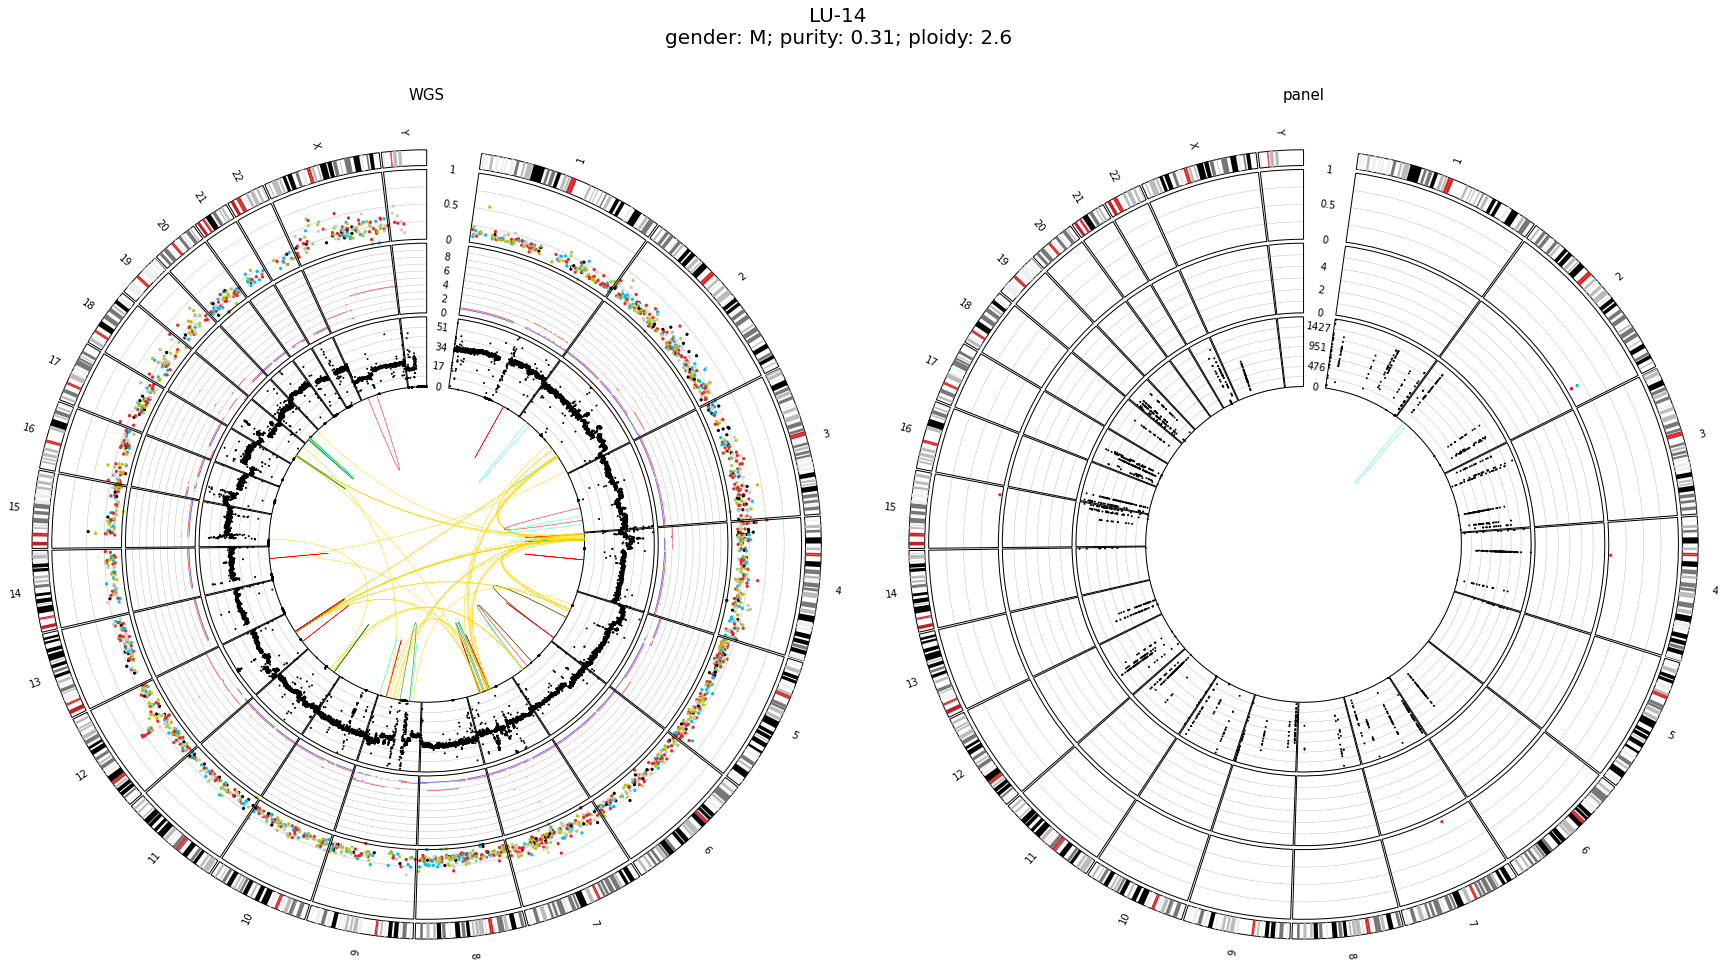

In [87]:
fig

In [82]:
fig.savefig('/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/24_circos/test.pdf')

In [18]:
WGS_SV_DFS['LU-FF6']

KeyError: 'LU-FF6'

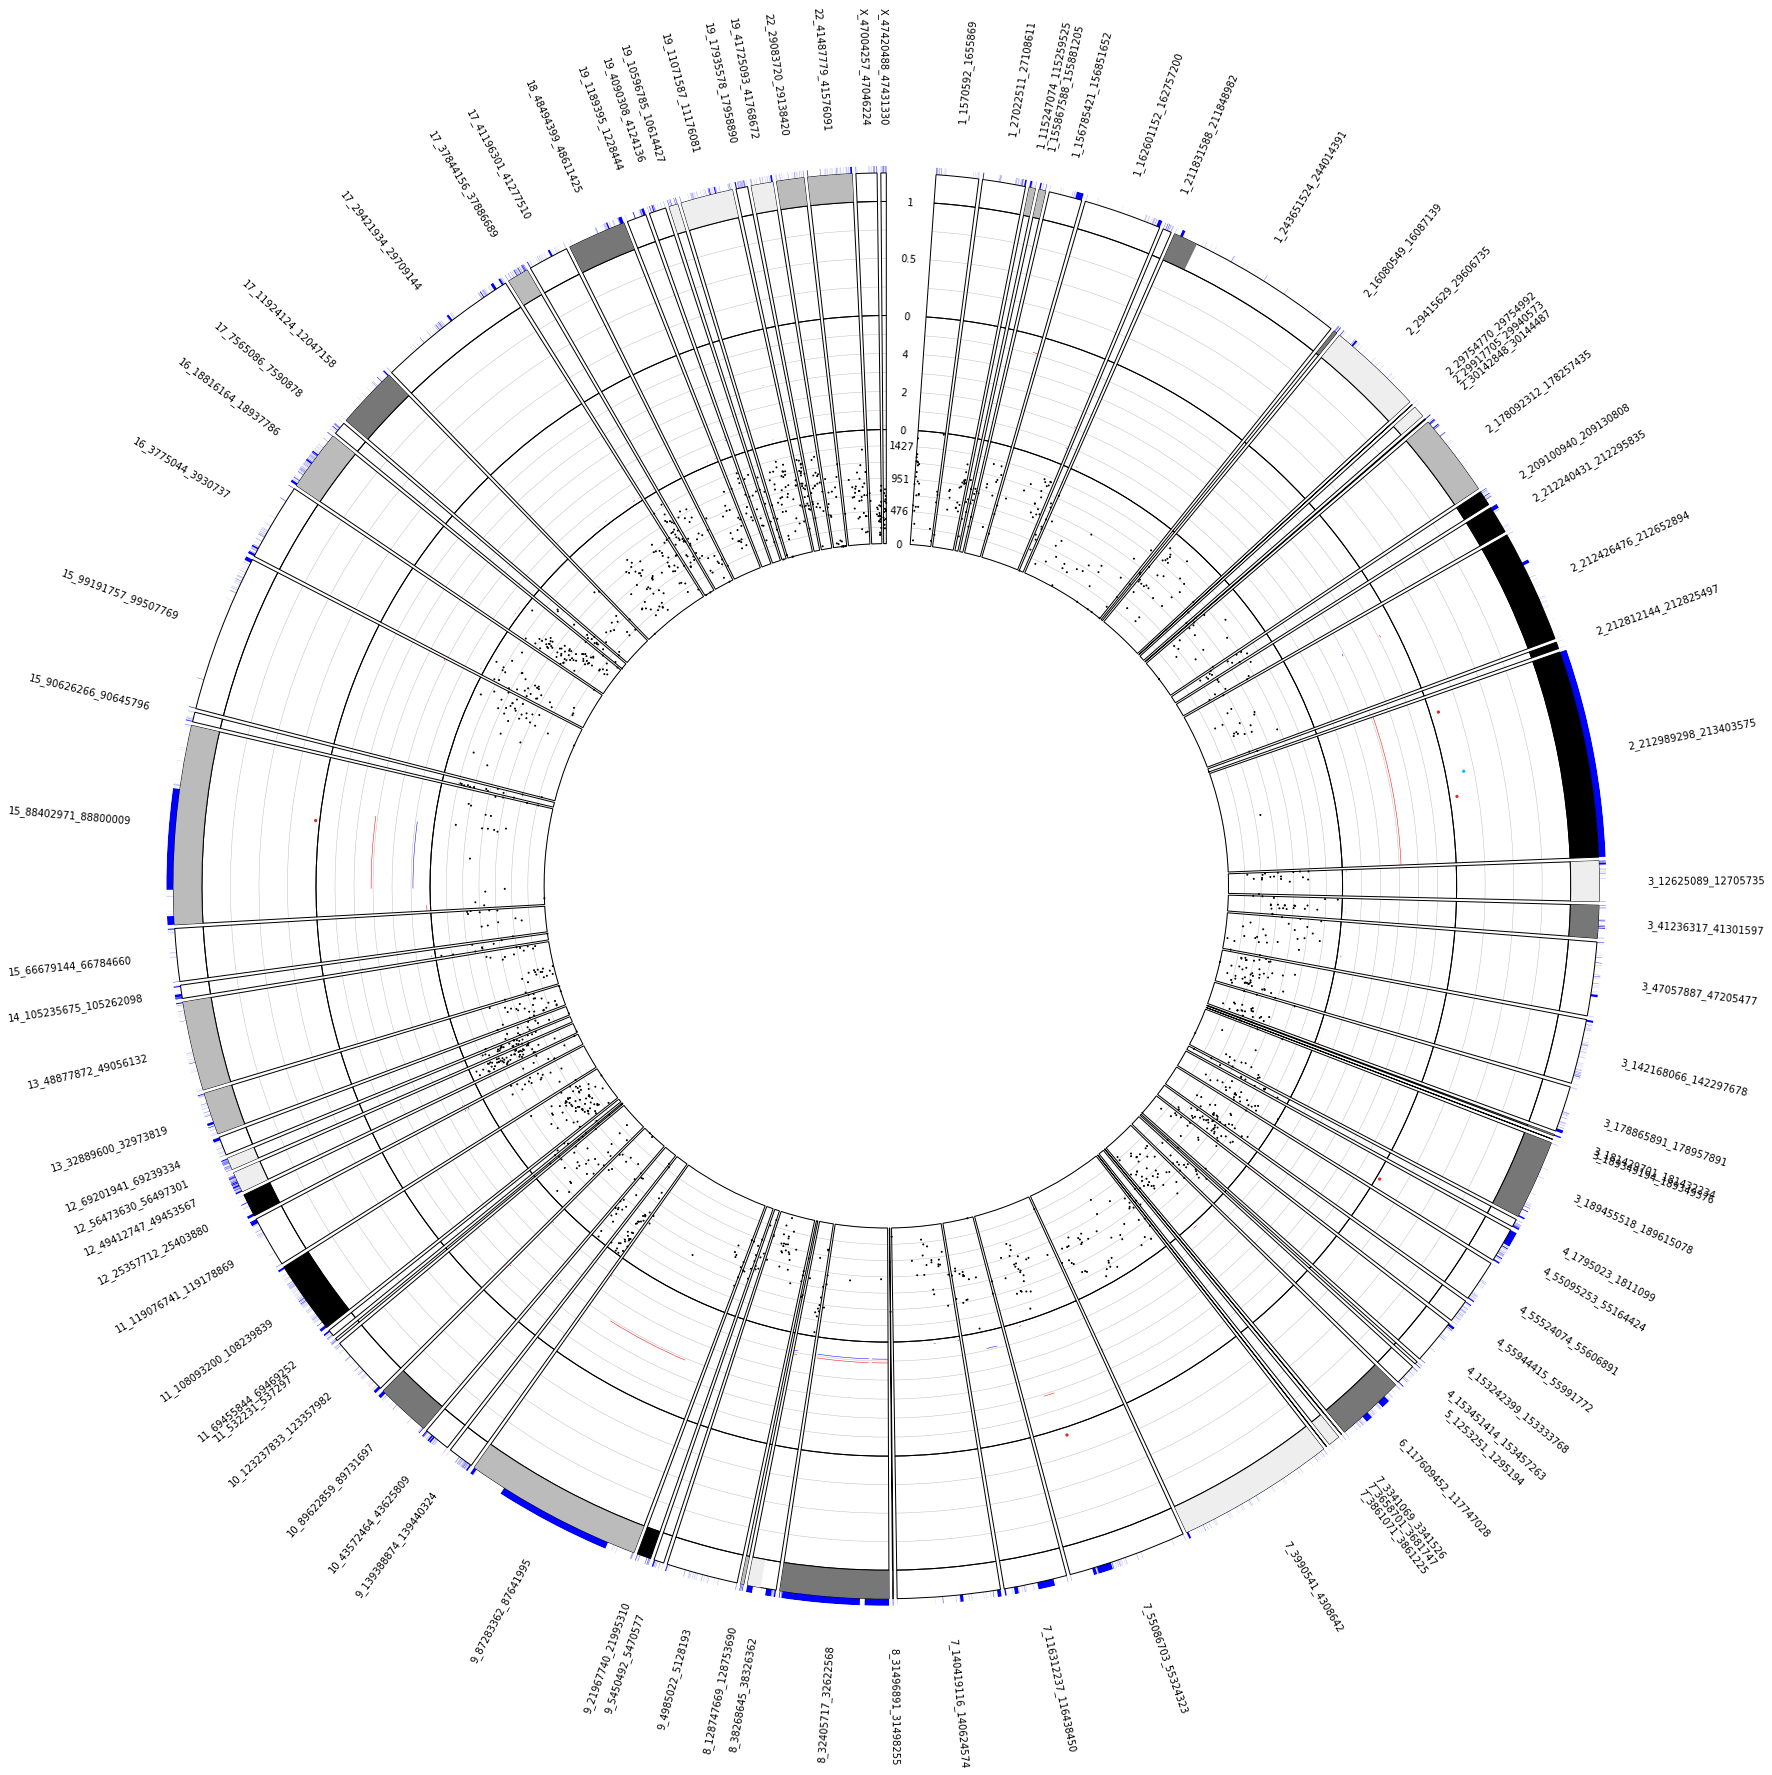

In [154]:
circos_panel.figure

# annotation interface example

In [30]:
# sampleid = SAMPLEIDS_LU[idx]
sampleid = 'LU-14'

sampleid_panel = sampleid + '_panel'

def vpfilter(vp):
    return allfilter(vp, sampleid_panel)

vcfp_indel.filter_vplist(vpfilter)
vcfp_snv.filter_vplist(vpfilter)

/home/users/pjh/scripts/python_genome_package_dev/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


In [39]:
vp = vcfp_snv.vplist_filtered[3]

In [47]:
vp.popfreq[0]

{'id': 'rs761924292',
 'dbSNPBuild': 144,
 'common': False,
 'freqs': {'1000Genomes': 0,
           'ALSPAC': 0.0002595,
           'Chileans': 0,
           'ChromosomeY': 0,
           'Daghestan': 0,
           'Estonian': 0,
           'ExAC': 4.125e-05,
           'FINRISK': 0,
           'GENOME_DK': 0,
           'GnomAD': 2.14e-05,
           'GnomAD_exomes': 2.787e-05,
           'GoESP': 0,
           'GoNL': 0,
           'HGDP_Stanford': 0,
           'HapMap': 0,
           'KOREAN': 0,
           'Korea1K': 0,
           'MGP': 0,
           'NorthernSweden': 0,
           'PAGE_STUDY': 0,
           'PRJEB36033': 0,
           'PRJEB37584': 0,
           'PRJEB37766': 0,
           'PharmGKB': 0,
           'Qatari': 0,
           'SGDP_PRJ': 0,
           'Siberian': 0,
           'TOMMO': 0,
           'TOPMED': 2.645e-05,
           'TWINSUK': 0.0002697,
           'Vietnamese': 0,
           'dbGaP_PopFreq': 0.0}}

In [50]:
vp.popfreq[0].get_freq('ExAC')

4.125e-05

In [51]:
vp.popfreq[0].get_freq('1000Genomes')

0

In [54]:
vp.vcfspec

<Vcfspec (4:55141027 G>A)>

In [53]:
vp.cosmic[0]

{'id': 'COSV57265823',
 'occurrence': {'endometrium': 1, 'large_intestine': 1},
 'portion_by_site': {'endometrium': 0.00022794620469569182,
                     'large_intestine': 2.2834699609526637e-05},
 'total_occurrence': 2,
 'total_portion': 6.80406338665451e-06,
 'occurrence_somatic': {'endometrium': 1, 'large_intestine': 1},
 'portion_by_site_somatic': {'endometrium': 0.00022794620469569182,
                             'large_intestine': 2.2834699609526637e-05},
 'total_occurrence_somatic': 2,
 'total_portion_somatic': 6.80406338665451e-06}

In [55]:
vp.cosmic[0]['total_occurrence']

2

In [56]:
vp.transcript[0]

{'ENST00000257290': {'id': 'ENST00000257290',
                     'biotype': 'protein_coding',
                     'consequences': ['missense_variant'],
                     'gene_id': 'ENSG00000134853',
                     'gene_name': 'PDGFRA',
                     'is_canonical': True,
                     'mane_select': None,
                     'refseq_id': 'NM_006206.4',
                     'ccds_id': 'CCDS3495.1',
                     'protein_id': 'ENSP00000257290',
                     'aa_change': ['R', 'H'],
                     'codon_change': ['cGc', 'cAc'],
                     'variant_pos_transcript': 2004,
                     'variant_pos_cds': 1673,
                     'variant_pos_protein': 558,
                     'hgvsc': 'ENST00000257290.5:c.1673G>A',
                     'hgvsp': 'ENSP00000257290.5:p.Arg558His',
                     'involved_exons': [12],
                     'involved_introns': None,
                     'is_exon_involved': True,
      

In [58]:
vp.transcript[0]['ENST00000257290']['gene_name']

'PDGFRA'

In [59]:
vp.transcript[0].canon_ovlp

{'ENST00000257290': {'id': 'ENST00000257290',
                     'biotype': 'protein_coding',
                     'consequences': ['missense_variant'],
                     'gene_id': 'ENSG00000134853',
                     'gene_name': 'PDGFRA',
                     'is_canonical': True,
                     'mane_select': None,
                     'refseq_id': 'NM_006206.4',
                     'ccds_id': 'CCDS3495.1',
                     'protein_id': 'ENSP00000257290',
                     'aa_change': ['R', 'H'],
                     'codon_change': ['cGc', 'cAc'],
                     'variant_pos_transcript': 2004,
                     'variant_pos_cds': 1673,
                     'variant_pos_protein': 558,
                     'hgvsc': 'ENST00000257290.5:c.1673G>A',
                     'hgvsp': 'ENSP00000257290.5:p.Arg558His',
                     'involved_exons': [12],
                     'involved_introns': None,
                     'is_exon_involved': True,
      

In [61]:
vp.transcript[0]['ENST00000257290']['is_exon_involved']

True